In [4]:
!pip install -U scikit-learn
!pip install autograd

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the follwing 2-class dataset:

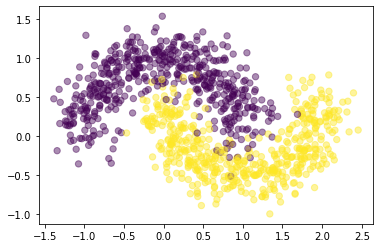

In [5]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

The number of nodes in the input layer will be determined by the dimensionality of our data (2). Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ y = softmax({z_2})$$

where $y$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

A common choice with the softmax output is the **cross-entropy loss**. If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength


In [7]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [8]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 5000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.579072
Loss after iteration 5000: 0.286239
Loss after iteration 10000: 0.254934
Loss after iteration 15000: 0.207199
Loss after iteration 20000: 0.172053
Loss after iteration 25000: 0.151550
Loss after iteration 30000: 0.138900
Loss after iteration 35000: 0.129118
Loss after iteration 40000: 0.119487
Loss after iteration 45000: 0.111079


In [9]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

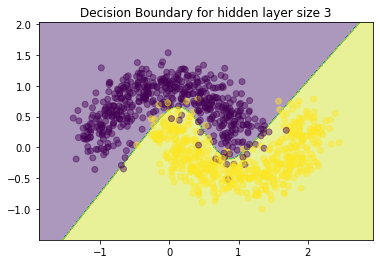

In [10]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

Add an additional layer to your neural network model. Change the activation function and use a ReLU. Does it work?


In [12]:
# We base our loss function on the previously defined one.
# All we are doing is adding an intermediate layer between layer '1' and layer '2', called layer 'N'.
def lossN(model):
    W1, b1, WN, bN, W2, b2 = model['W1'], model['b1'], model['WN'], model['bN'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    # Here we add the new layer, consuming the output a1
    zN = np.dot(a1,WN) + bN
    aN = sigma(zN)
    # The rest stays the same, but layer 2 will consume the output of layer N
    z2 = np.dot(aN,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss. We had too change a little bit this line.
    corect_logprobs = -np.log(probs[range(num_examples), y.astype(int)])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
# The prediction function changes in the same way the loss function did.
def predictN(model, x):
    W1, b1, WN, bN, W2, b2 = model['W1'], model['b1'], model['WN'], model['bN'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    zN = np.dot(a1,WN) + bN
    aN = sigma(zN)
    z2 = np.dot(aN,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [13]:
# We define a method to build the new model. We have to consider the new layer.
def build_modelN(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    # We add the new layer and define its dimmensions. As it is the intermediate one, we must set all its dimensions to nn_hdim to make it fit with the other two layers.
    WN = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    bN = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'WN': WN, 'bN': bN, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        # We use the new prediction method
        predictN(model, X)

        # computing the derivative by AD
        # We use the new loss        
        gradient_loss = grad(lossN)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 5000 == 0:
            print("Loss after iteration %i: %f" %(i, lossN(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
modelN = build_modelN(3, print_loss=True)

Loss after iteration 0: 0.614322
Loss after iteration 5000: 0.284951
Loss after iteration 10000: 0.267852
Loss after iteration 15000: 0.260531
Loss after iteration 20000: 0.188256
Loss after iteration 25000: 0.112467
Loss after iteration 30000: 0.096238
Loss after iteration 35000: 0.089653
Loss after iteration 40000: 0.086953
Loss after iteration 45000: 0.085809


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3 with an additional layer')

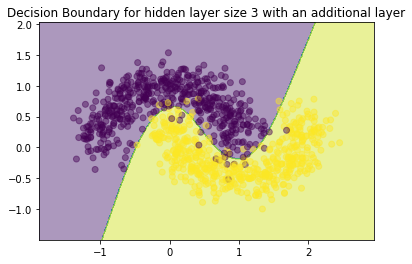

In [15]:
# We draw the result of an initial test with tanh as an activation function
plot_decision_boundary(lambda x: predictN(modelN, x))
plt.title("Decision Boundary for hidden layer size 3 with an additional layer")

Loss after iteration 0: 0.608898
Loss after iteration 5000: 0.278292
Loss after iteration 10000: 0.263362
Loss after iteration 15000: 0.256404
Loss after iteration 20000: 0.253121
Loss after iteration 25000: 0.251530
Loss after iteration 30000: 0.250753
Loss after iteration 35000: 0.250302
Loss after iteration 40000: 0.249929
Loss after iteration 45000: 0.249545


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3 with an additional layer with ReLU')

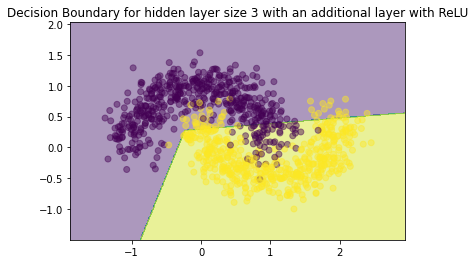

In [16]:
# In order to do what the exercise asks us to do, we change the activation function to ReLu and compare the results
def reLU(x):
    return np.maximum(0, x)

sigma = reLU

modelN = build_modelN(3, print_loss=True)
plot_decision_boundary(lambda x: predictN(modelN, x))
plt.title("Decision Boundary for hidden layer size 3 with an additional layer with ReLU")

Choosing ReLu as activation function leads to worse results. Even though most of all yellow points are well classified, it looks like that ReLU with this number of layers and dimensions does not handle the division curves right. The generalization is really bad.

# Exercise 2

Design (change parameters) and train a NN to classify the following dataset. 


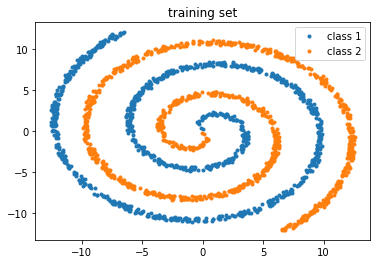

In [17]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)
num_examples = len(X)
sigma = np.tanh # activation function

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [18]:
# We dedicided to have 5 layers given the number of turns each spiral takes, and taking into account how the previous exercises turned out. We need to define a new loss function:
def lossNMQ(model):
    W1, b1, WN, bN, WM, bM, WQ, bQ, W2, b2 = model['W1'], model['b1'], model['WN'], model['bN'], model['WM'], model['bM'], model['WQ'], model['bQ'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    # We add 3 extra hidden layers as we added 1 before
    zN = np.dot(a1,WN) + bN
    aN = sigma(zN)
    zM = np.dot(aN,WM) + bM
    aM = sigma(zM)
    zQ = np.dot(aM,WQ) + bQ
    aQ = sigma(zQ)    
    z2 = np.dot(aQ,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y.astype(int)])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# We define a new prediction function suitable for the new structure:
# forward propagation
def predictNMQ(model, x):
    W1, b1, WN, bN, WM, bM, WQ, bQ, W2, b2 = model['W1'], model['b1'], model['WN'], model['bN'], model['WM'], model['bM'], model['WQ'], model['bQ'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    zN = np.dot(a1,WN) + bN
    aN = sigma(zN)
    zM = np.dot(aN,WM) + bM
    aM = sigma(zM)
    zQ = np.dot(aM,WQ) + bQ
    aQ = sigma(zQ)    
    z2 = np.dot(aQ,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [20]:
# We define a new model building method. The inner dimensions between our recently added layers could be diferent to the nn_hdim value, but in order to simplify, we will always use the same value.
def build_modelNMQ(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    WN = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    bN = np.zeros((1, nn_hdim))
    WM = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    bM = np.zeros((1, nn_hdim))
    WQ = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    bQ = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'WN': WN, 'bN': bN, 'WM': WM, 'bM': bM, 'WQ': WQ, 'bQ': bQ, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        # We should remember to use the new prediction method and the new loss function.
        predictNMQ(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(lossNMQ)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 5000 == 0:
            print("Loss after iteration %i: %f" %(i, lossNMQ(model)))
    
    return model

Loss after iteration 0: 0.735348
Loss after iteration 5000: 0.614244
Loss after iteration 10000: 0.602783
Loss after iteration 15000: 0.591098
Loss after iteration 20000: 0.578657
Loss after iteration 25000: 0.565216
Loss after iteration 30000: 0.549163
Loss after iteration 35000: 0.526741
Loss after iteration 40000: 0.472127
Loss after iteration 45000: 0.561938


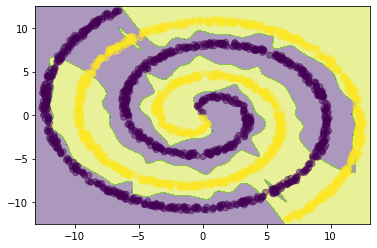

In [21]:
# We test the new structure, with tanh as activation value initally and 25 as hidden dimensions. (20 as hidden dimension also works fine, but with a lower value things start to go worse)
modelNMQ = build_modelNMQ(25, print_loss=True)
plot_decision_boundary(lambda x: predictNMQ(modelNMQ, x))

Loss after iteration 0: 0.904939
Loss after iteration 5000: 0.634757
Loss after iteration 10000: 0.620856
Loss after iteration 15000: 0.612596
Loss after iteration 20000: 0.600702
Loss after iteration 25000: 0.497467
Loss after iteration 30000: 0.024338
Loss after iteration 35000: 0.005783
Loss after iteration 40000: 0.002932
Loss after iteration 45000: 0.001884


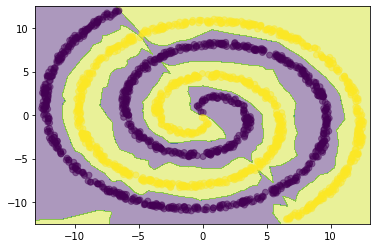

In [22]:
# Now, let's repeat the same experiment but changing the activation function
# activation function
def reLU(x):
    return np.maximum(0, x)


sigma = reLU
modelNMQ = build_modelNMQ(25, print_loss=True)
plot_decision_boundary(lambda x: predictNMQ(modelNMQ, x))

We can see how now, with more cells and different data, the ReLU activation function based experiment works much better, adapting much better its prediction to the double spiral shape.